In [65]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sio

In [4]:
data_path = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig3_ver01_221025_data119.cathodic.dF.dFF'

test = sio.loadmat(data_path)
test

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 25 18:34:27 2022',
 '__version__': '1.0',
 '__globals__': [],
 'data119_cathodic_dF': array([[[-144.8, -130.8, -154.8, ..., -210.8, -228.8, -228.8],
         [-165.2, -145.2, -137.2, ..., -295.2, -283.2, -289.2],
         [-148.8, -100.8, -144.8, ..., -196.8, -268.8, -274.8],
         ...,
         [-118. ,  -90. , -112. , ..., -150. , -192. , -190. ],
         [-116. , -150. , -124. , ..., -212. , -218. , -216. ],
         [-144.8, -148.8, -150.8, ..., -198.8, -194.8, -216.8]],
 
        [[-124.4, -126.4, -156.4, ..., -206.4, -204.4, -198.4],
         [-131.2, -133.2, -129.2, ..., -243.2, -225.2, -245.2],
         [-123.6, -121.6, -151.6, ..., -179.6, -251.6, -245.6],
         ...,
         [-134. , -148. , -142. , ..., -158. , -196. , -218. ],
         [-149.2, -161.2, -129.2, ..., -217.2, -231.2, -223.2],
         [-142.4, -150.4, -148.4, ..., -176.4, -188.4, -188.4]],
 
        [[-157.2, -145.2, -159.2, ..

In [5]:
test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data119_cathodic_dF', 'data119_cathodic_dFF'])

In [57]:
print(test['data119_cathodic_dF'].shape)

print(test['data119_cathodic_dF'].min())
print(test['data119_cathodic_dF'].max())

print(test['data119_cathodic_dFF'].shape)

print(test['data119_cathodic_dFF'].min())
print(test['data119_cathodic_dFF'].max())

(80, 80, 5000)
-456.0
-16.799999999999955
(80, 80, 5000)
-0.329004329004329
-0.014856738592147112


In [23]:
# The F0 value will be somewhere between these two below values.
print(test['data119_cathodic_dF'].min() / test['data119_cathodic_dFF'].min())
print(test['data119_cathodic_dF'].max() / test['data119_cathodic_dFF'].max())

1386.0
1130.8


In [72]:
# Rescale the data to 0 ~ 255 and level down the color range for dF
dF = np.swapaxes(test['data119_cathodic_dF'], 0, -1)
dF = np.swapaxes(dF, 1, -1)
X = (dF - dF.min(axis=0)) / (dF.max(axis=0) - dF.min(axis=0))
X *= 255

level_num = 4.
one_interval = 255 / level_num
X /= one_interval
X = np.floor(X)
X[X == level_num] = level_num - 1
unique, counts = np.unique(X, return_counts=True)
print(unique, counts)
X *= 255

# Rescale the data to 0 ~ 255 and level down the color range for dFF
dFF = np.swapaxes(test['data119_cathodic_dFF'], 0, -1)
dFF = np.swapaxes(dFF, 1, -1)
XX = (dFF - dFF.min(axis=0)) / (dFF.max(axis=0) - dFF.min(axis=0))
XX *= 255

level_num = 4.
one_interval = 255 / level_num
XX /= one_interval
XX = np.floor(XX)
XX[XX == level_num] = level_num - 1
unique, counts = np.unique(XX, return_counts=True)
print(unique, counts)
XX *= 255

[0. 1. 2. 3.] [   17413   912679 23830068  7239840]
[0. 1. 2. 3.] [   17571   942692 23858976  7180761]


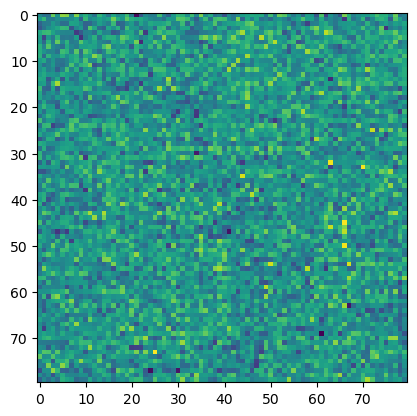

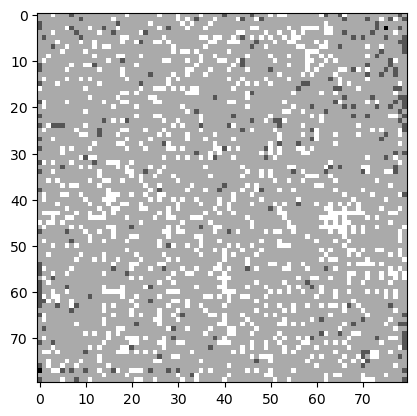

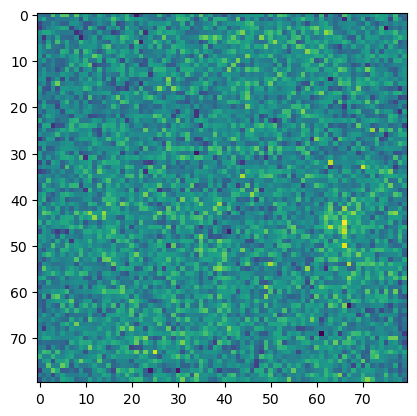

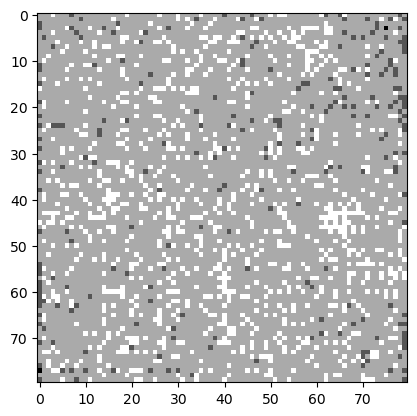

In [77]:
plt.imshow(test['data119_cathodic_dF'][:, :, 1447])
plt.show()

plt.imshow(X[1447, :, :], cmap='gray')
plt.show()

plt.imshow(test['data119_cathodic_dFF'][:, :, 1447])
plt.show()

plt.imshow(XX[1447, :, :], cmap='gray')
plt.show()

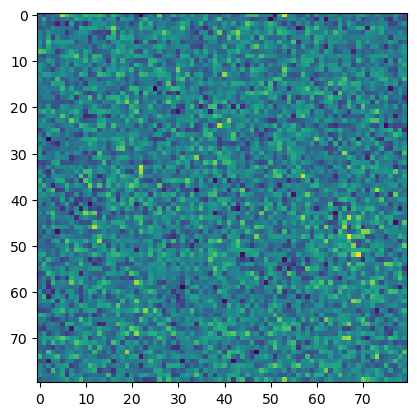

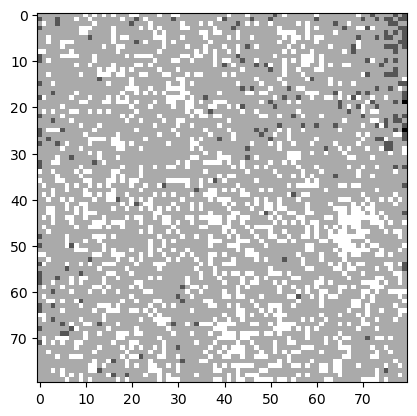

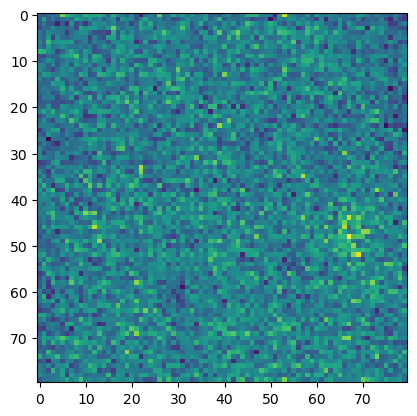

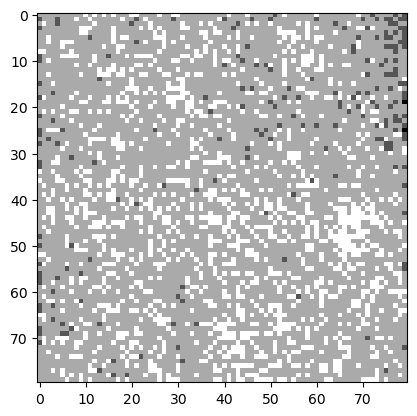

In [78]:
plt.imshow(test['data119_cathodic_dF'][:, :, 1647])
plt.show()

plt.imshow(X[1647, :, :], cmap='gray')
plt.show()

plt.imshow(test['data119_cathodic_dFF'][:, :, 1647])
plt.show()

plt.imshow(XX[1647, :, :], cmap='gray')
plt.show()

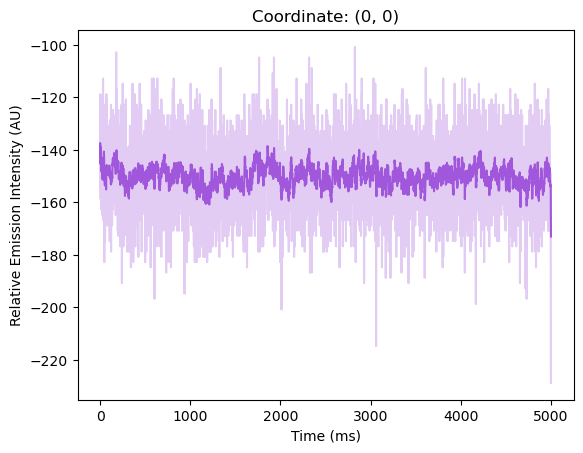

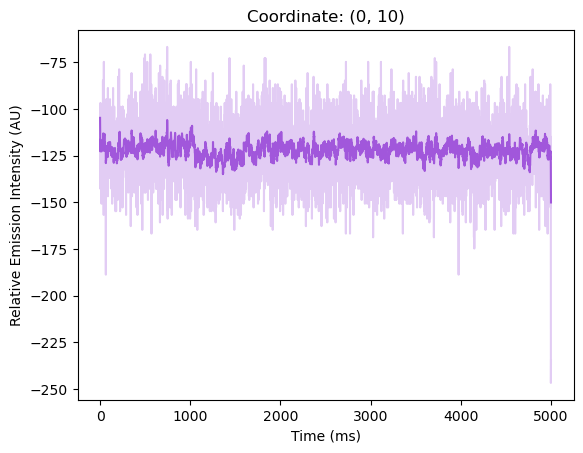

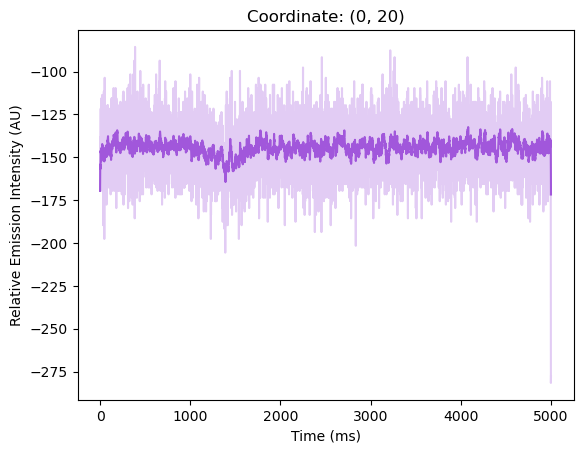

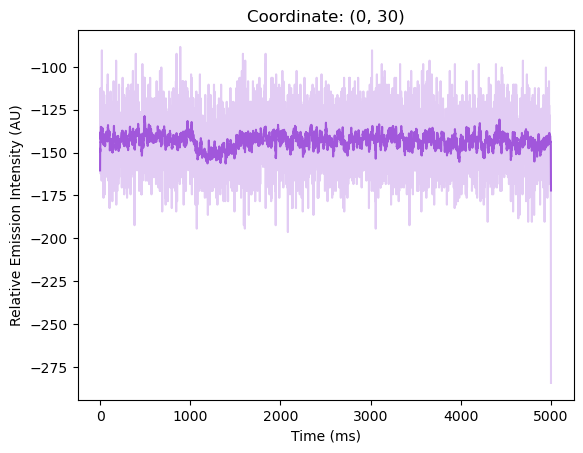

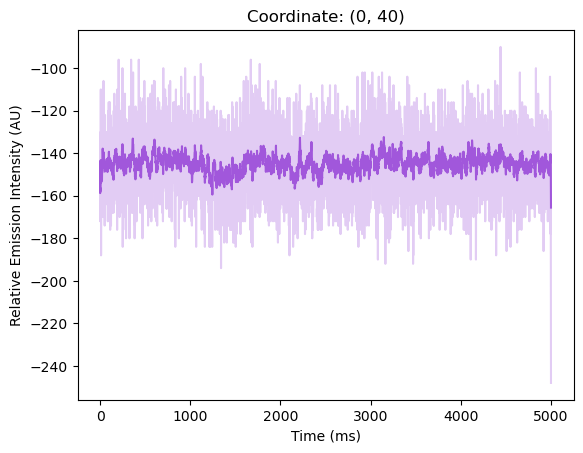

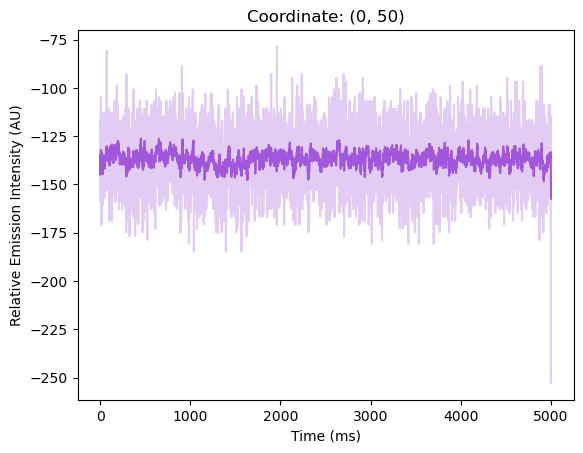

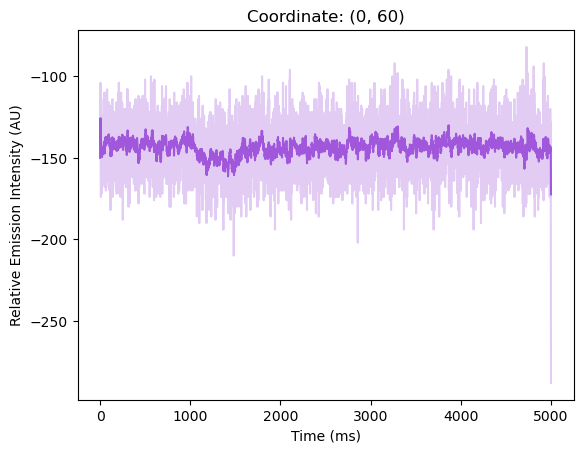

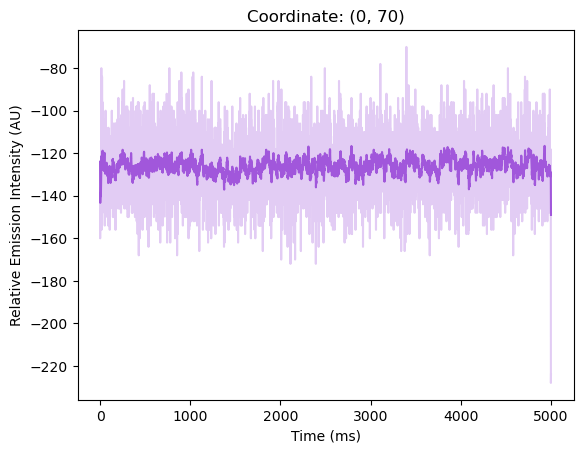

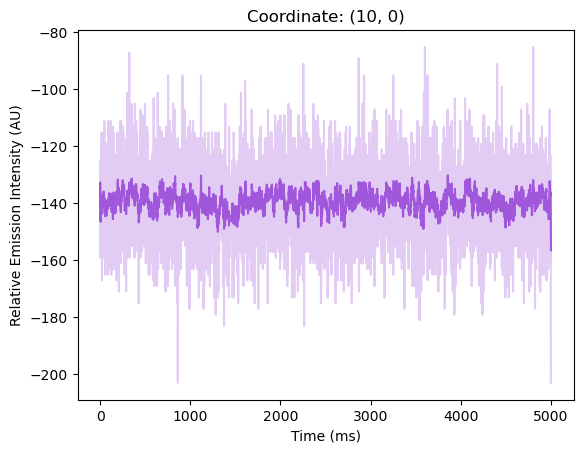

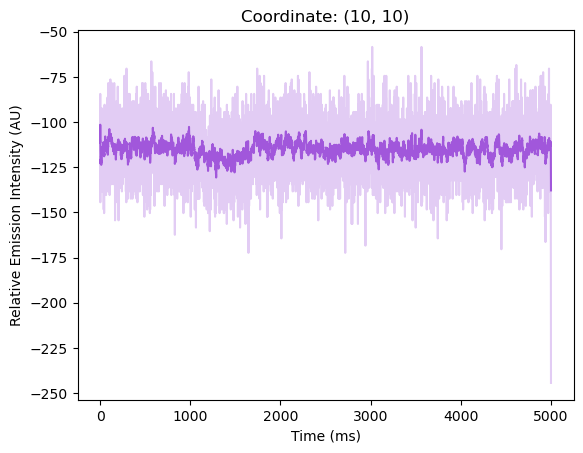

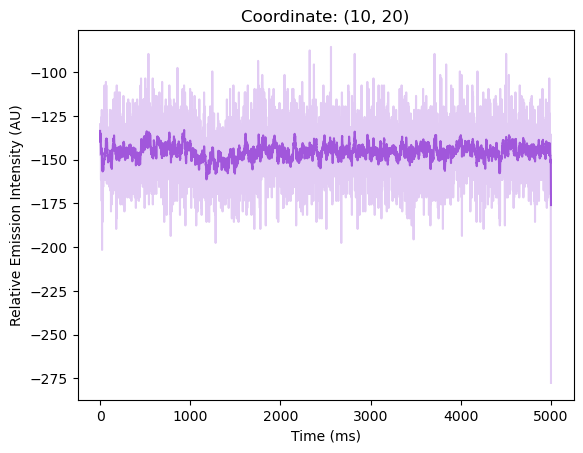

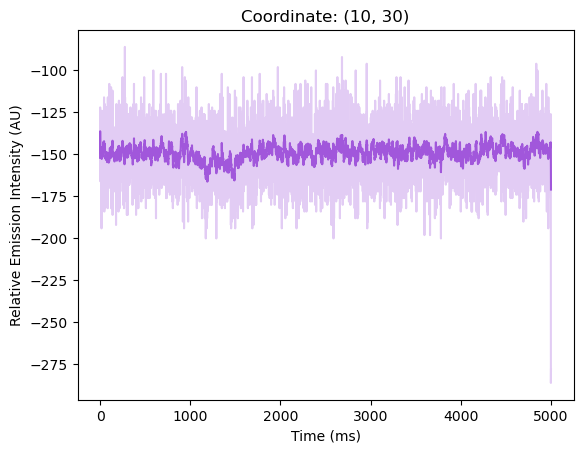

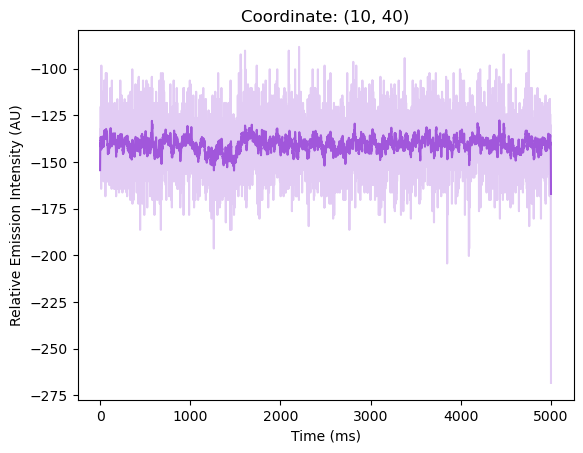

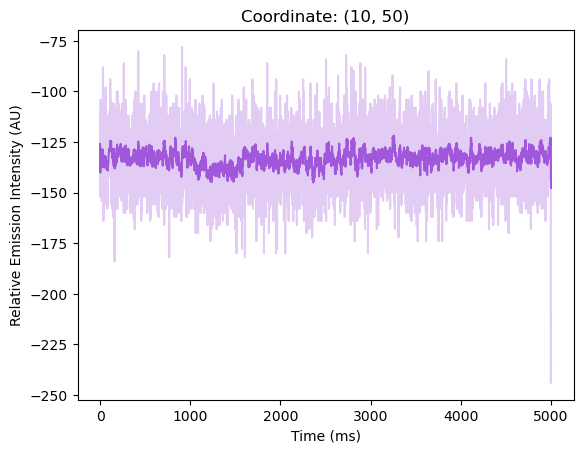

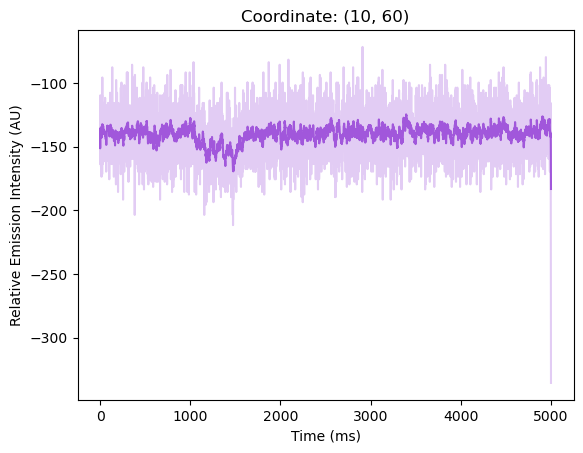

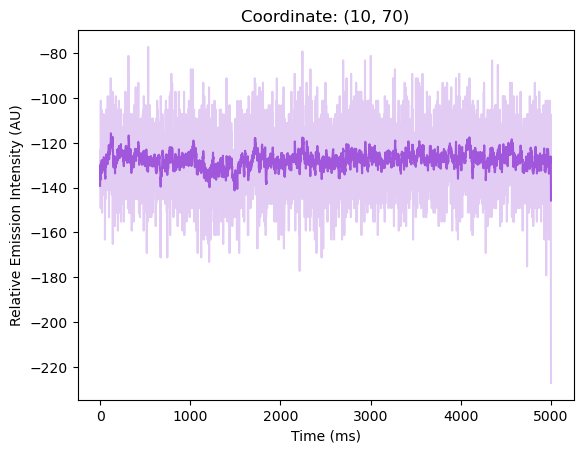

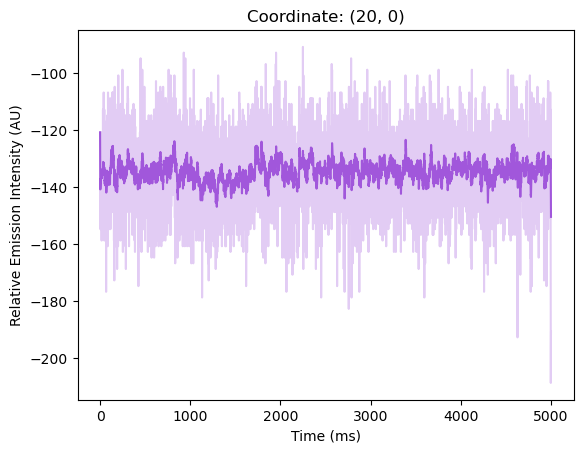

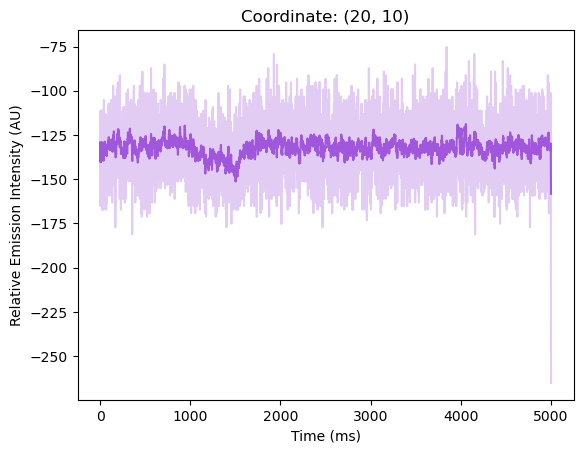

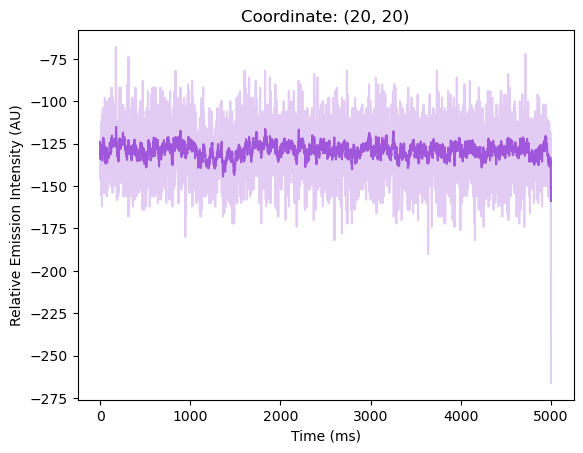

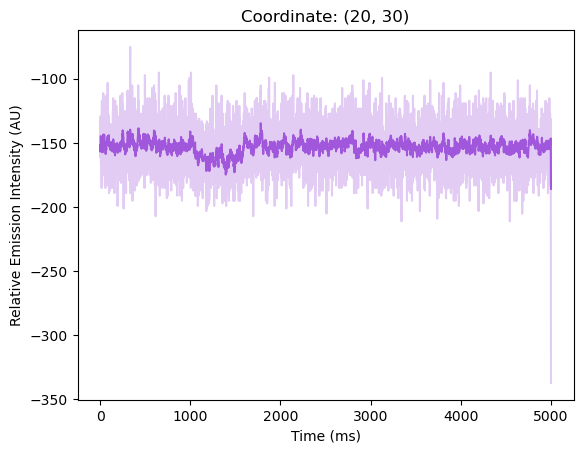

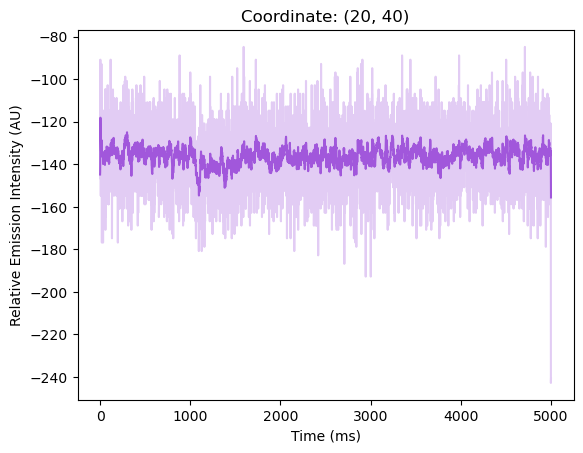

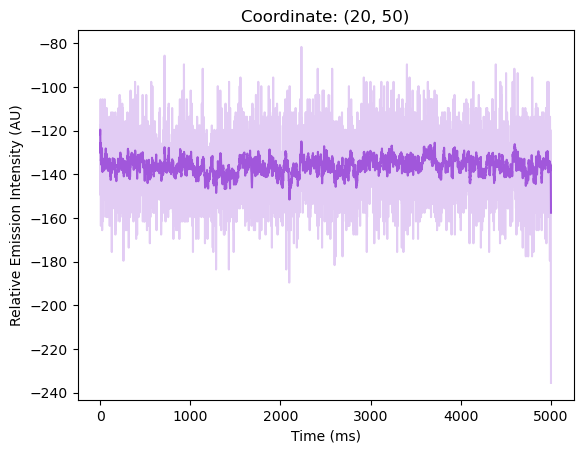

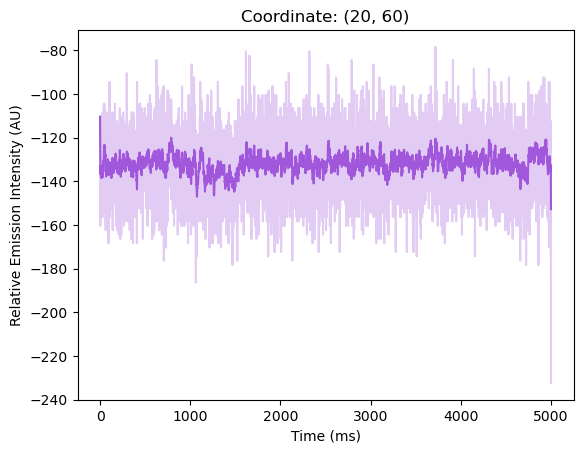

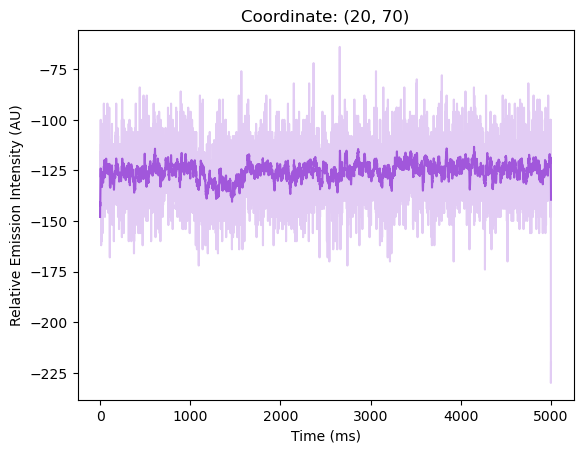

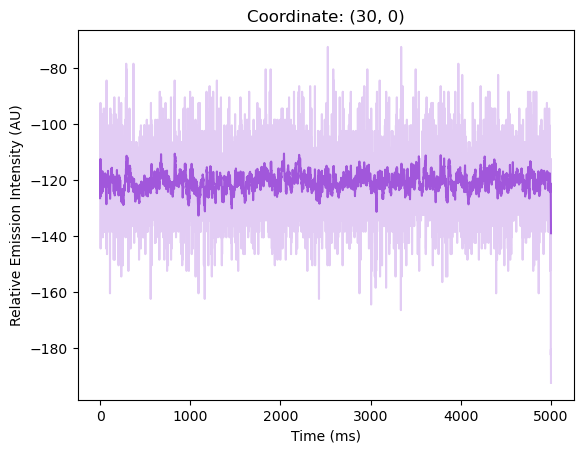

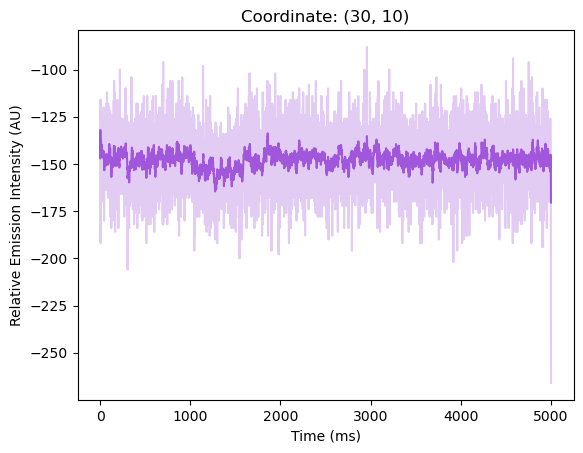

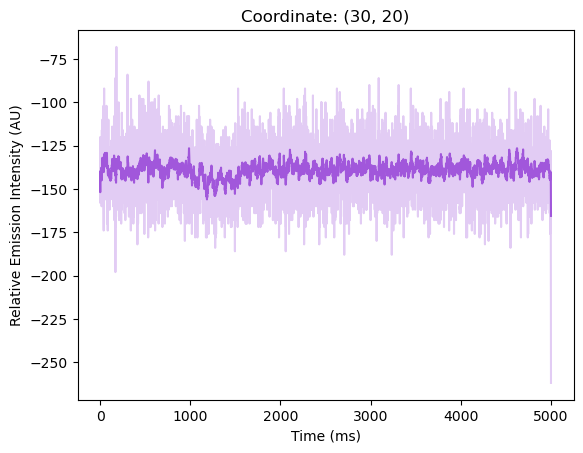

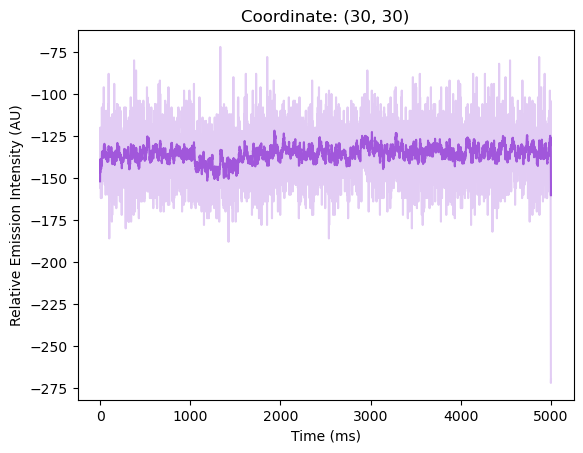

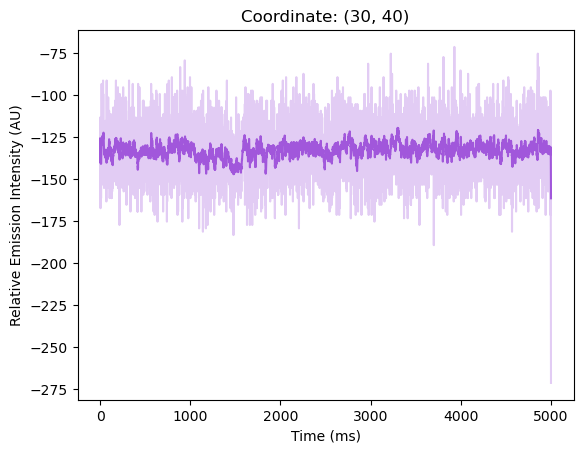

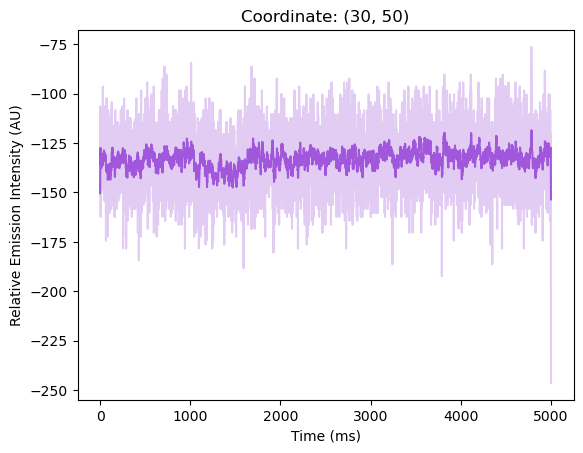

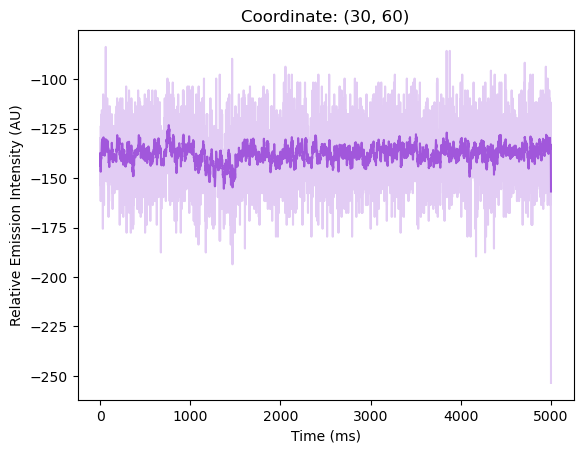

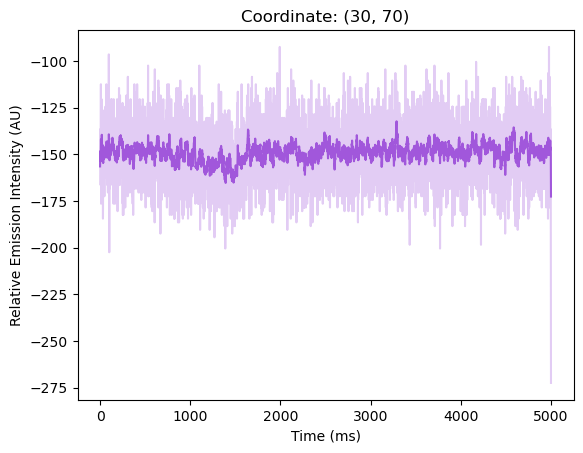

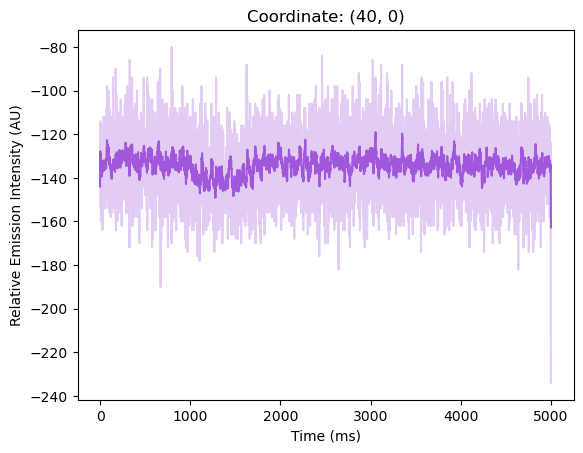

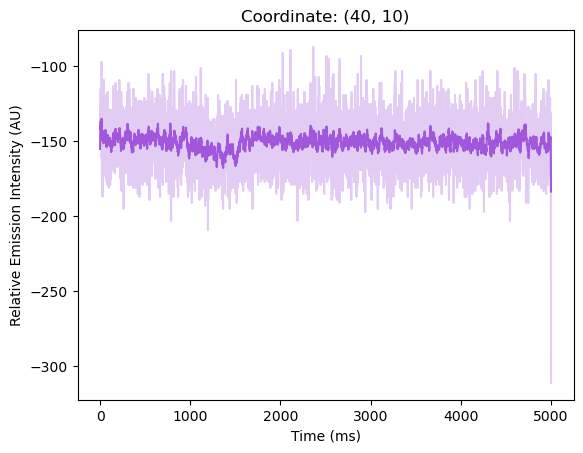

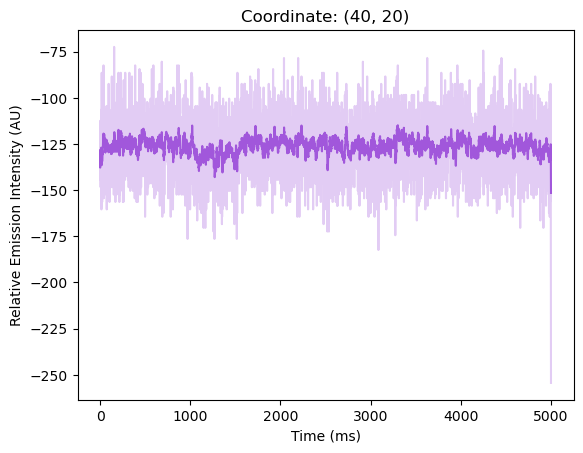

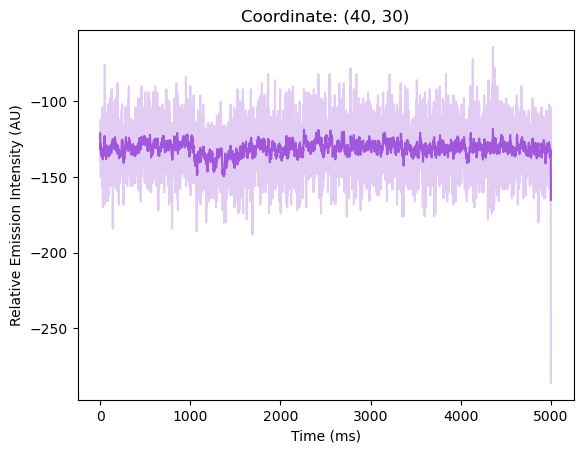

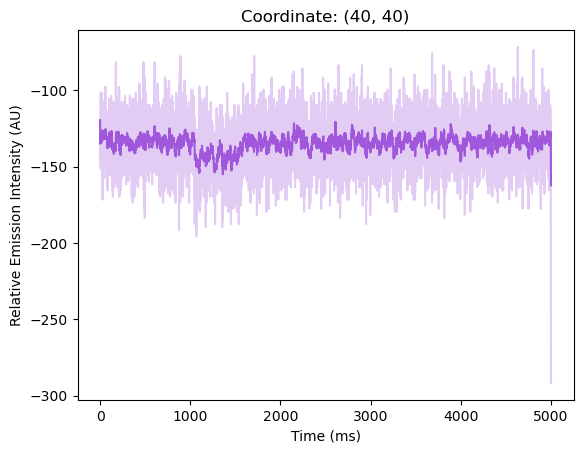

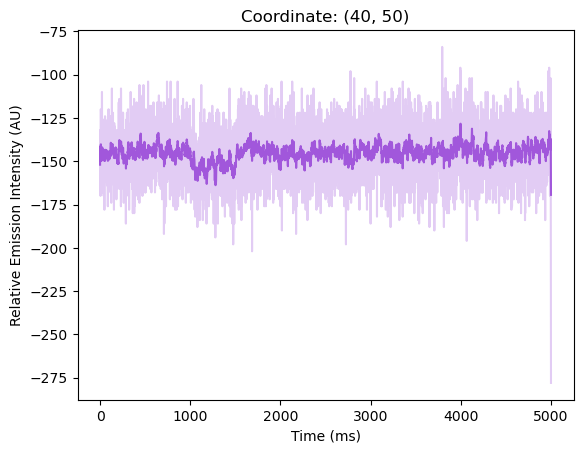

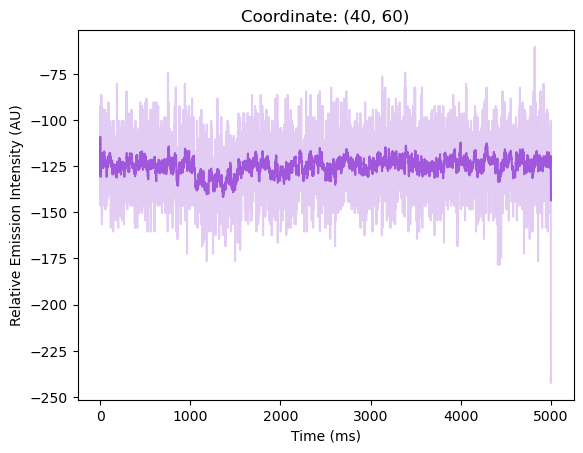

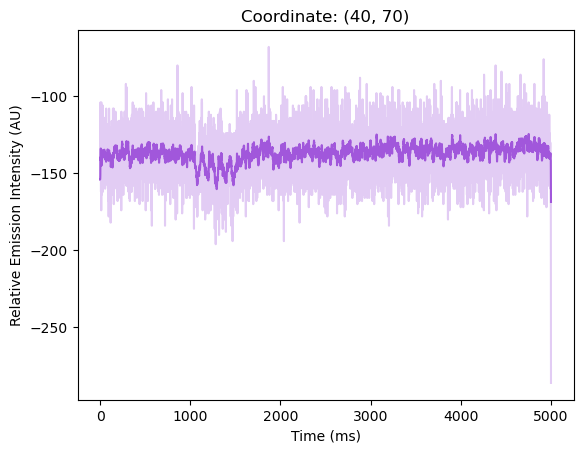

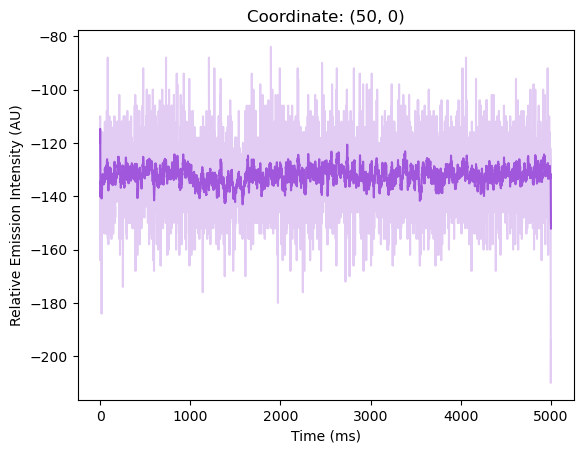

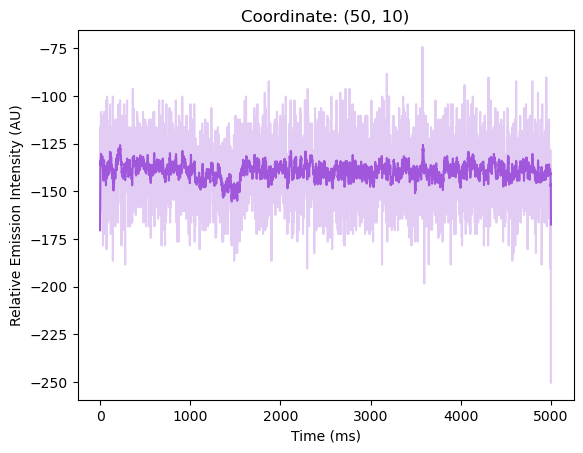

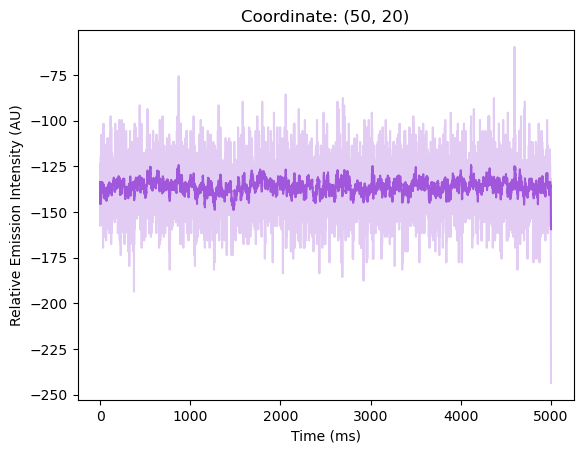

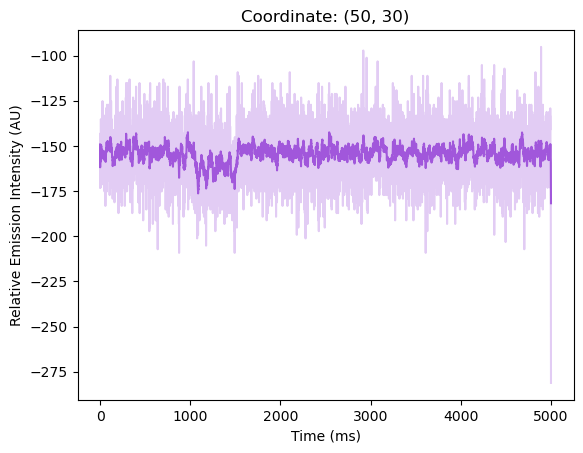

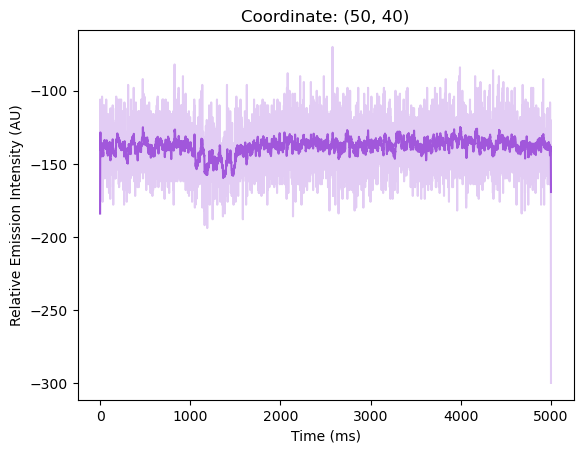

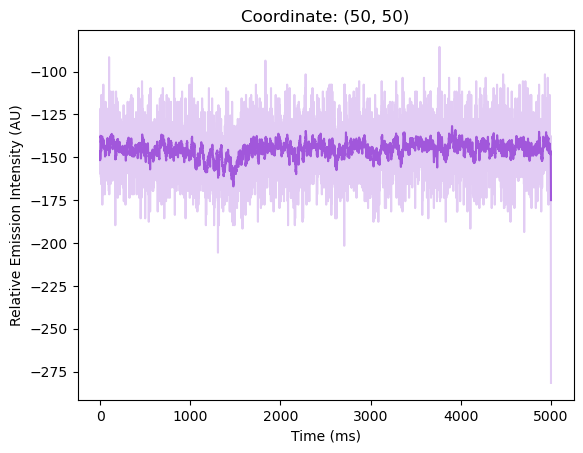

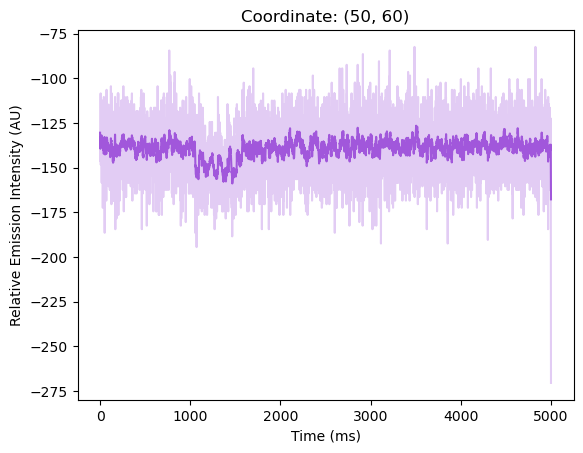

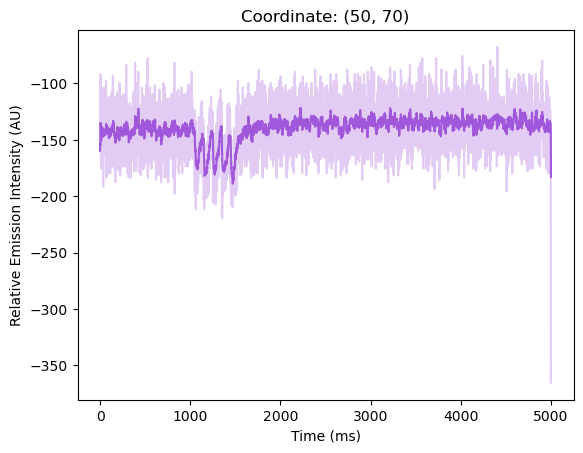

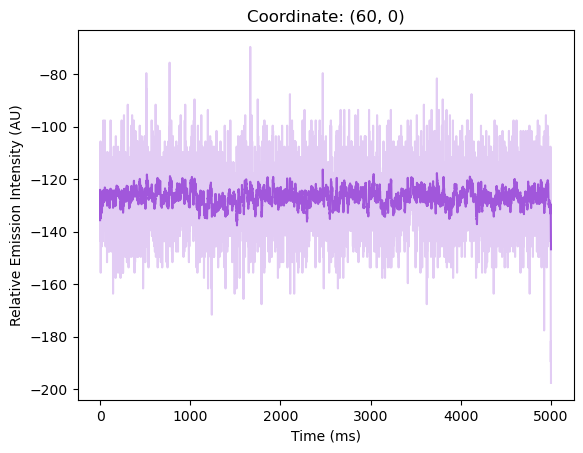

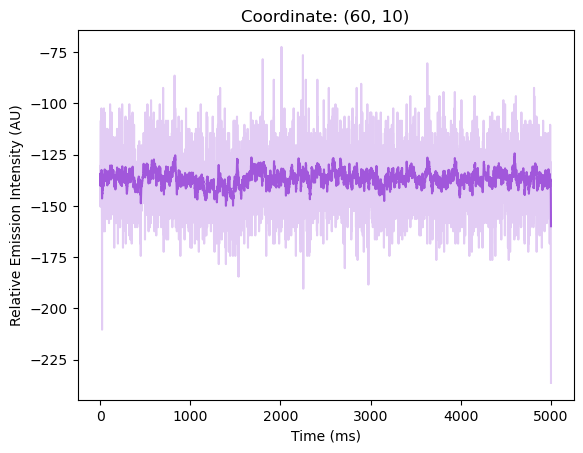

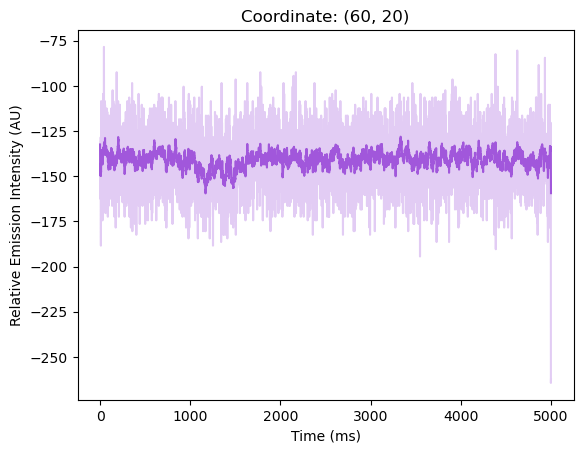

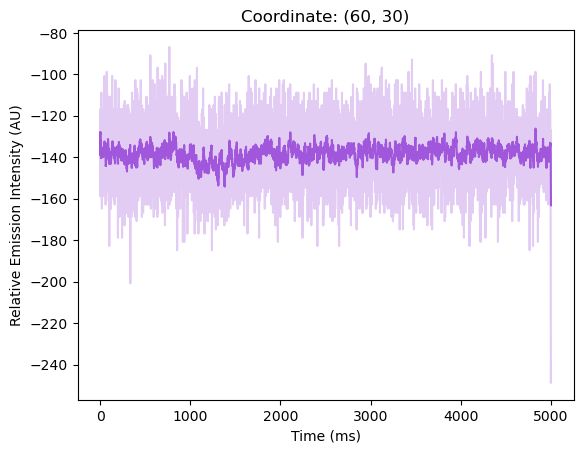

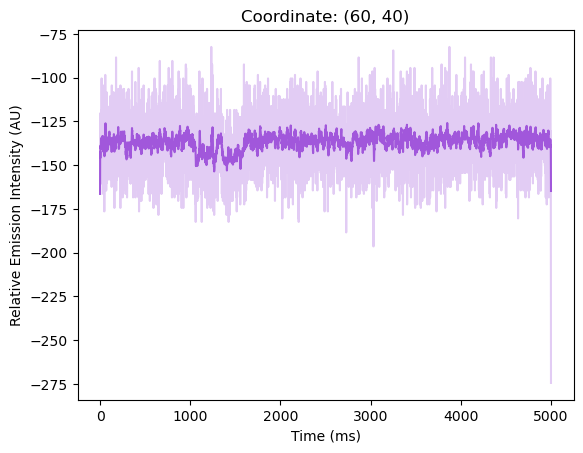

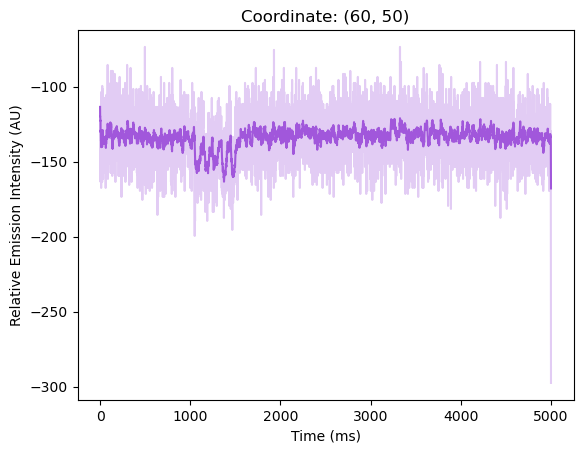

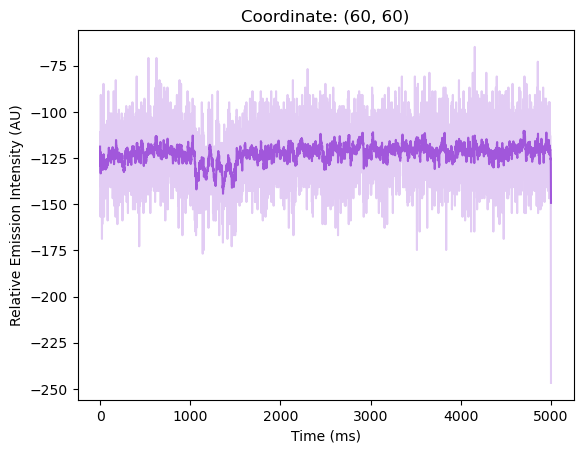

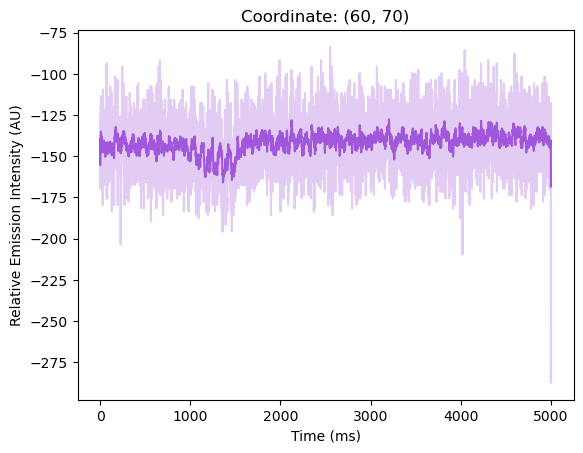

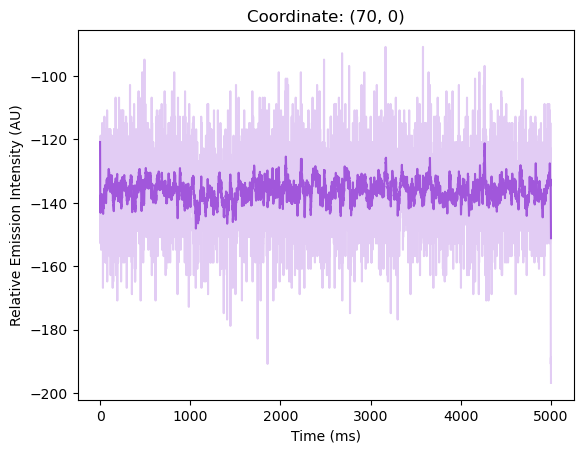

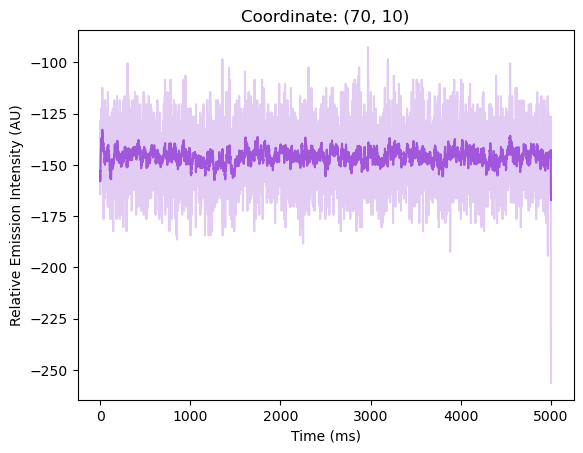

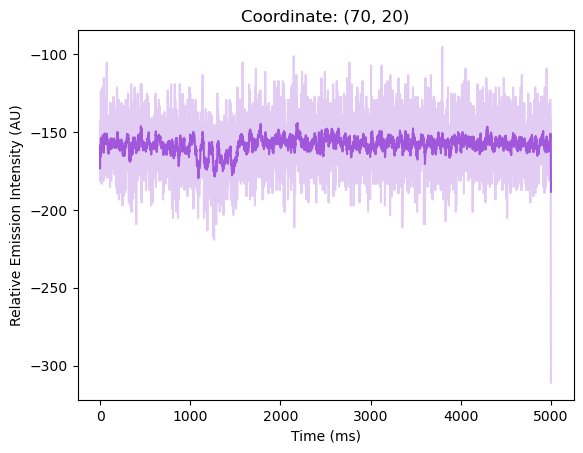

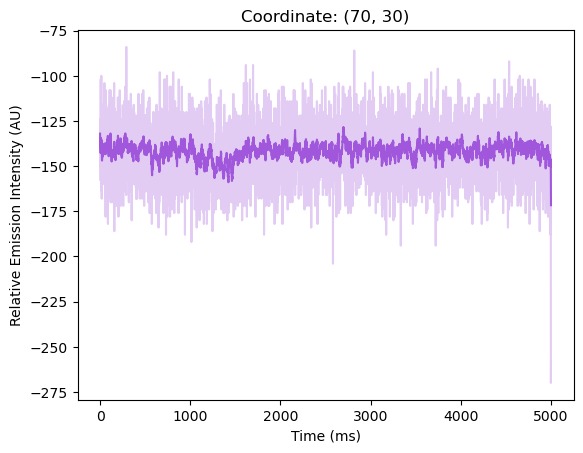

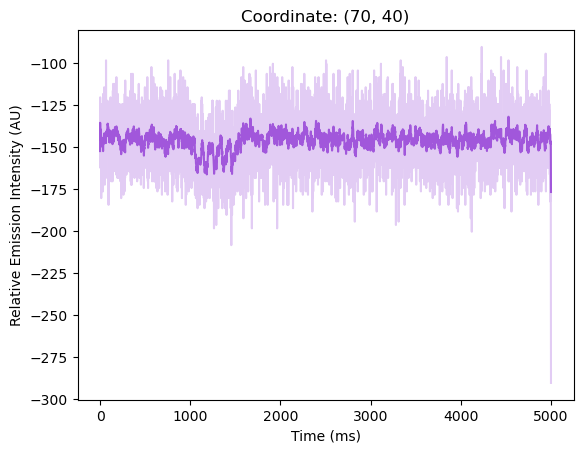

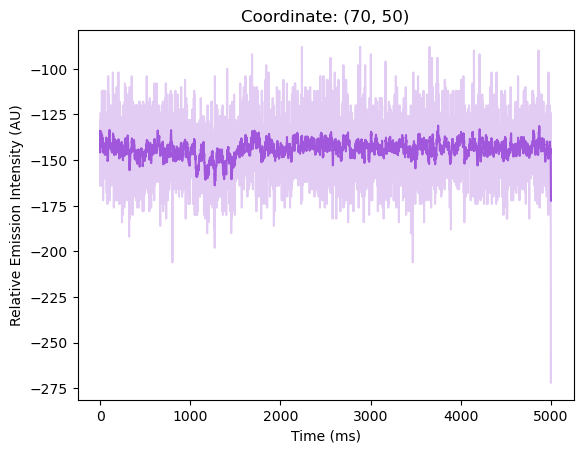

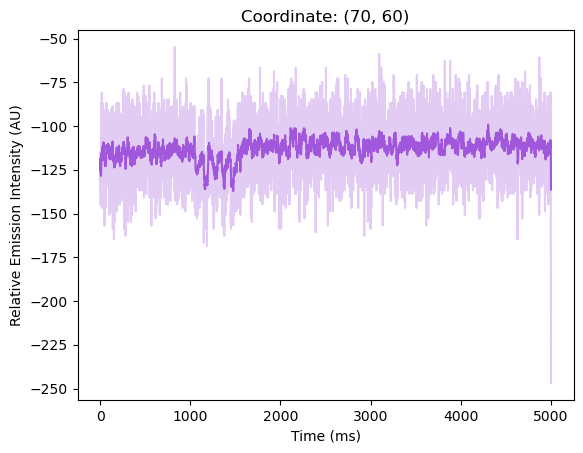

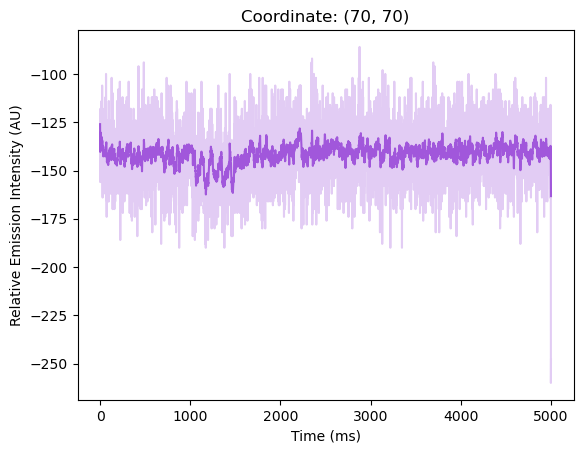

In [83]:
x_coord = 50
y_coord = 70

os.chdir('c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3')
for x_coord in range(0, test['data119_cathodic_dF'].shape[0], 10):
    for y_coord in range(0, test['data119_cathodic_dF'].shape[1], 10):
        pix_lst = []
        for i in range(test['data119_cathodic_dF'].shape[-1]):
            pix_lst.append(test['data119_cathodic_dF'][x_coord, y_coord, i])
        pix_array = np.array(pix_lst)
        ema = pd.Series(pix_array).ewm(alpha=0.1).mean().reset_index()

        sns.lineplot(data=pix_array, alpha=0.3, color=sns.color_palette('hls', 8)[-2])
        sns.lineplot(data=ema[0], color=sns.color_palette('hls', 8)[-2])
        plt.title(f'Coordinate: ({x_coord}, {y_coord})')
        plt.xlabel('Time (ms)')
        plt.ylabel('Relative Emission Intensity (AU)')
        plt.savefig(f'c:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\figures\\Fig3\\{x_coord}_{y_coord}.png')
        plt.show()